# Create Distance Infographic - Cosmic Explorer Trade Study 

This Notebook reads from the output of Bayesian inference runs and creates a distance infographic for measuring the parameters of a CBC signal to within 10% accuracy.

### Import modules

In [2]:
import numpy
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Patch
import seaborn as sns
from glob import glob

plt.style.use('dark_background')
%matplotlib inline


In [3]:
# sns.palplot(sns.light_palette("orange", 4))
palette = sns.color_palette("Blues_r", 4)

# define a dictionary to standardize the colors for different parameters
color_dict = {'EOS':palette[0], 'sky loc':palette[2], 
#               'inclination':palette[2],
              'Masses':palette[1], 'Mchirp':palette[3]}

In [4]:
def plot_dist_bar(network_dict, nw_number):
    '''
    Evaluates the x-ranges for the broken bar for
    each parameter from the dictionary values. Plots 
    the broken bars for each parameter.
    
    Parameters
    ----------
    network_dict: dictionary
        Dictionary with the disctance values
    
    nw_number: int
        Number id for the detctor network
    '''
    # get the x-ranges from dict values
    eos_nw = [0, network_dict['EOS'] - 0]
    masses_nw = [network_dict['EOS'], network_dict['Masses']-network_dict['EOS']]
    sky_loc_nw = [network_dict['Masses'], network_dict['sky loc']-network_dict['Masses']]
#     inc_nw = [network_dict['sky loc'], network_dict['inclination']-network_dict['sky loc']]
#     masses_nw = [network_dict['inclination'], network_dict['Masses']-network_dict['inclination']]    

    mchirp_nw = [network_dict['sky loc'], network_dict['Mchirp']-network_dict['sky loc']]
    
    # plot the broken bars
    p = ax.barh(10*nw_number, eos_nw[1], left=eos_nw[0], height = 5, 
                color=color_dict['EOS'], label=str(int(network_dict['EOS'])))
    ax.bar_label(p, label_type='edge', c='k')
    p = ax.barh(10*nw_number, sky_loc_nw[1], left=sky_loc_nw[0], height = 5, 
                color=color_dict['sky loc'], label=str(int(network_dict['sky loc'])))
    ax.bar_label(p, label_type='edge', c='k')
#     p = ax.barh(10*nw_number, inc_nw[1], left=inc_nw[0], height = 5, 
#                 color=color_dict['inclination'], label=str(int(network_dict['inclination'])))
    ax.bar_label(p, label_type='edge', c='k')
    p = ax.barh(10*nw_number, masses_nw[1], left=masses_nw[0], height = 5, 
                color=color_dict['Masses'], label=str(int(network_dict['Masses'])))
    ax.bar_label(p, label_type='edge', c='k')
    p = ax.barh(10*nw_number, mchirp_nw[1], left=mchirp_nw[0], height = 5, 
                color=color_dict['Mchirp'], label=str(int(network_dict['Mchirp'])))
    ax.bar_label(p, label_type='edge')

    

### Plotting the timelines

{'Name': 'CE40-CE20-LIO', 'EOS': 1000, 'sky loc': 2000, 'inclination': 2500, 'Masses': 3000, 'Mchirp': 10000}
plotting distances for network CE40-CE20-LIO
{'Name': 'CE40-CE20-LIO', 'EOS': 1000, 'sky loc': 2000, 'inclination': 2500, 'Masses': 3000, 'Mchirp': 10000}
plotting distances for network CE40-CE20-LIO


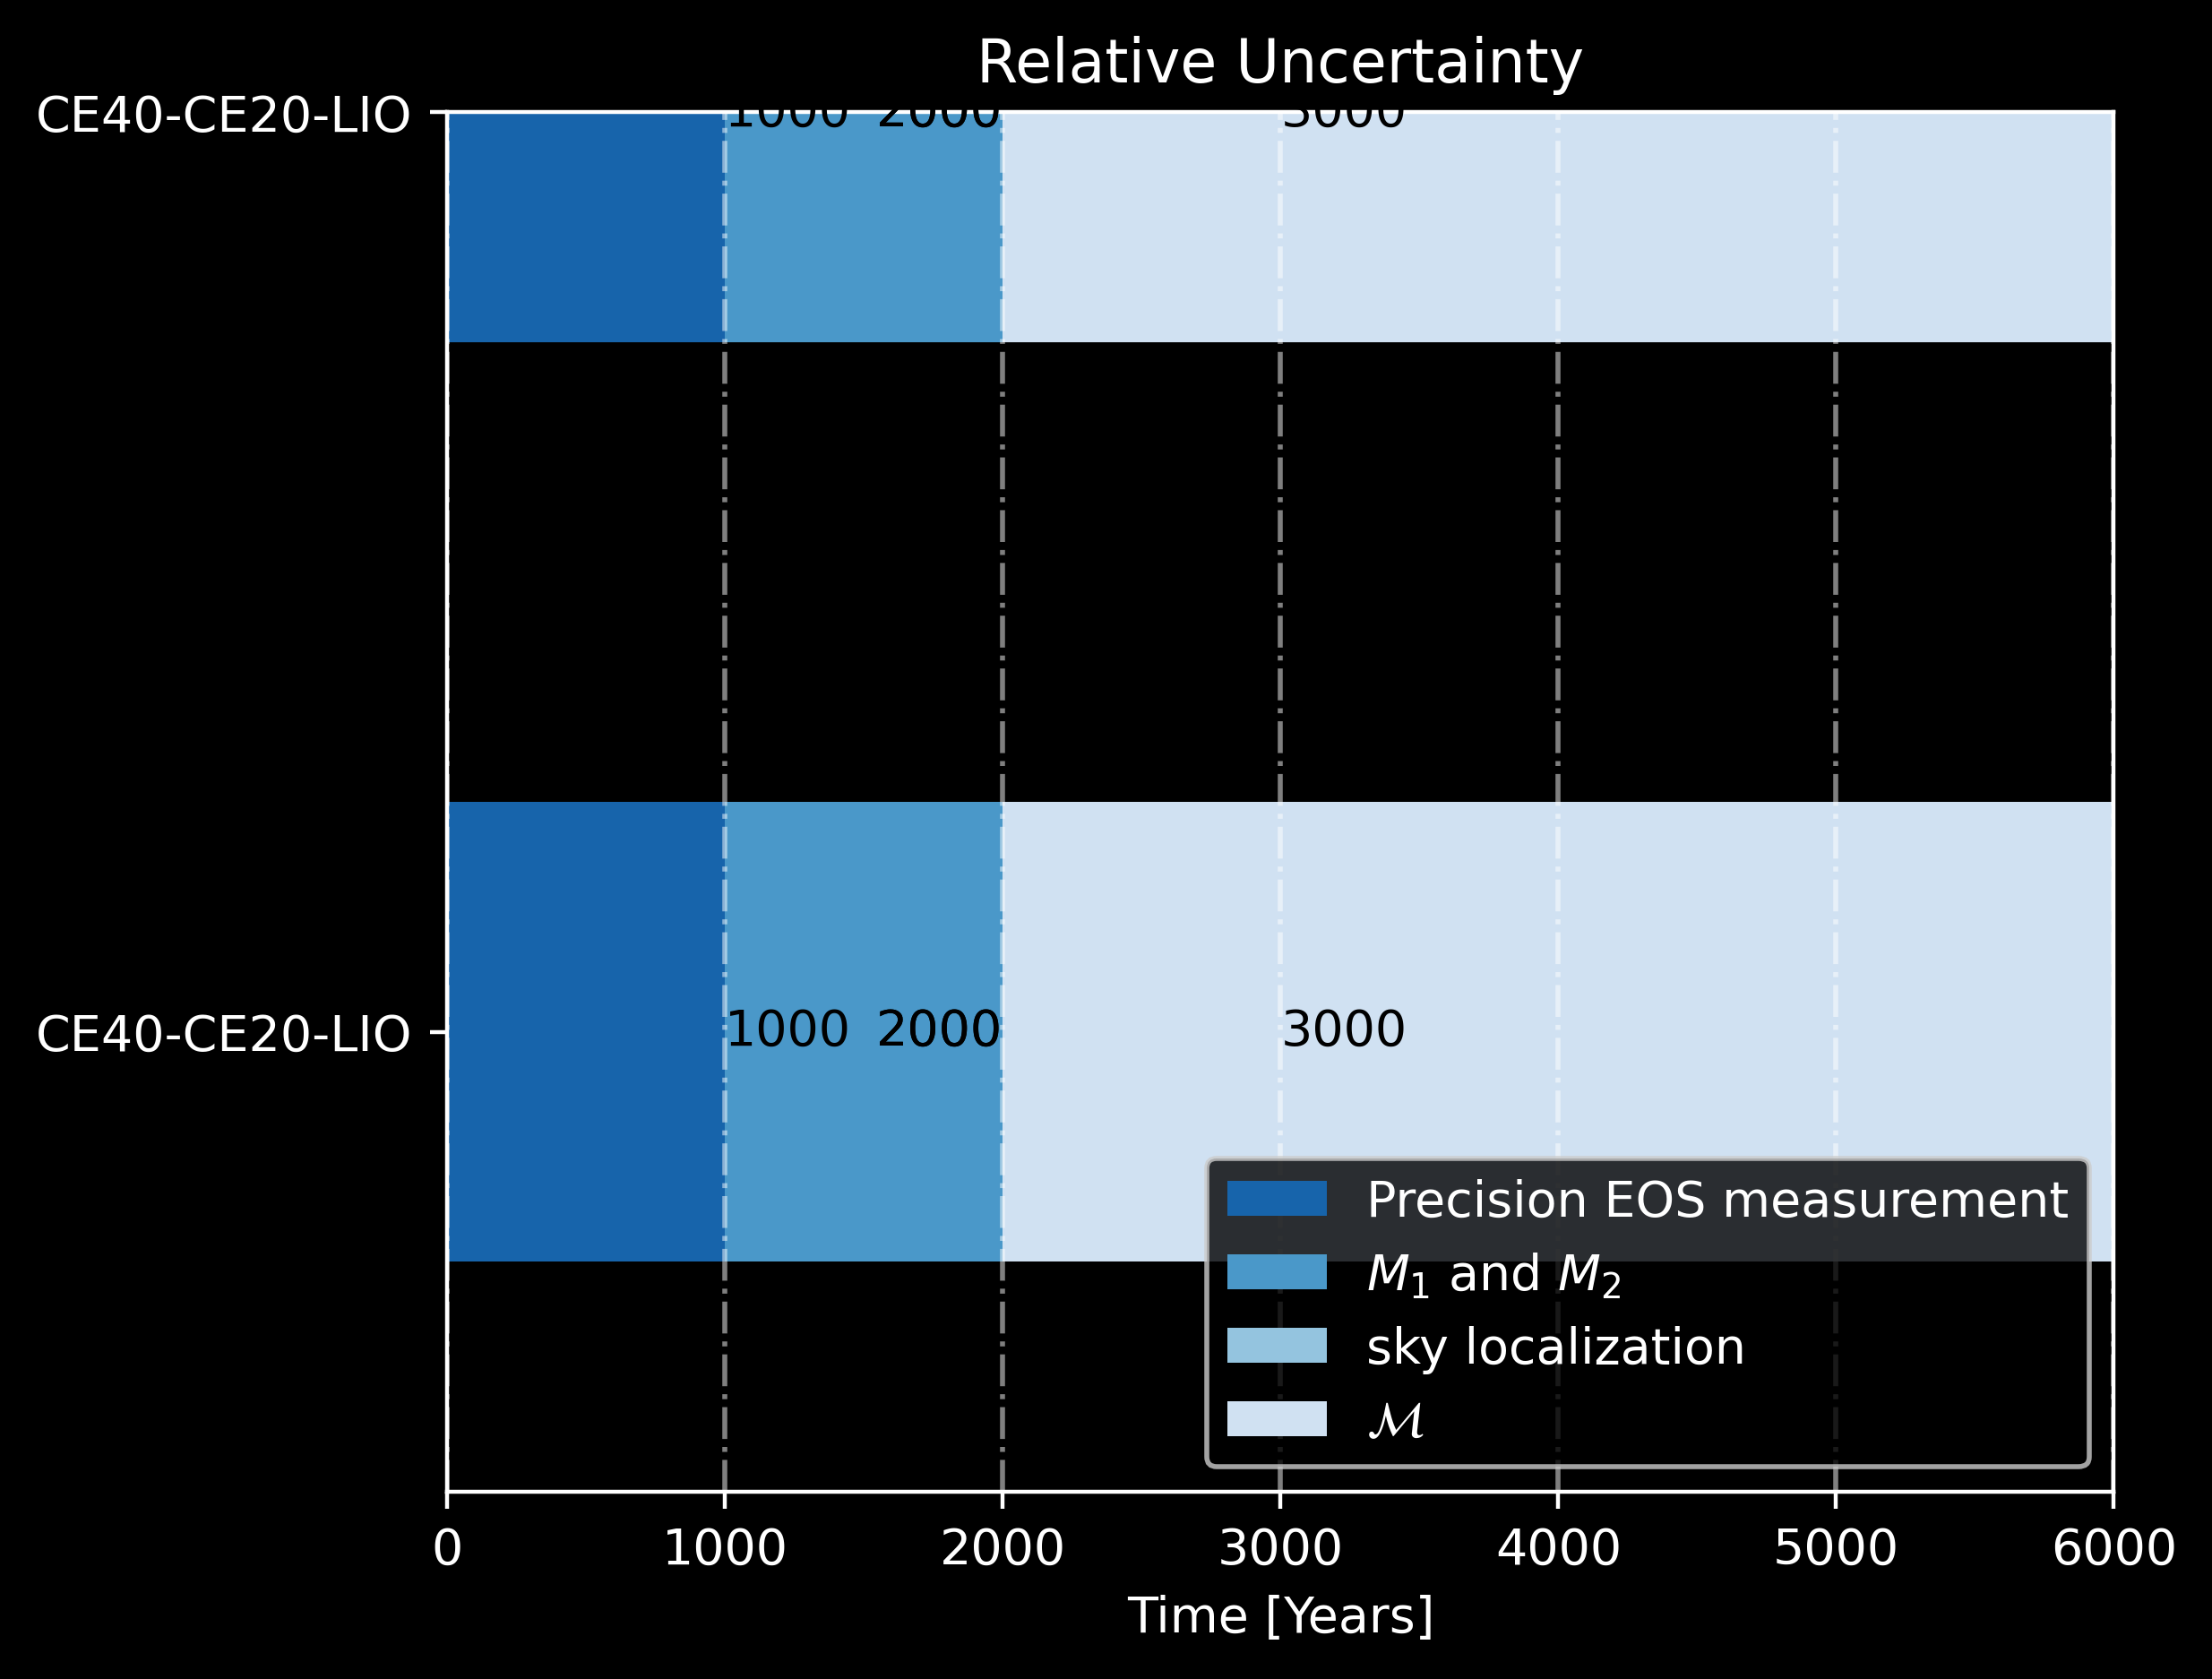

In [24]:
# list of all the network files
network_list = sorted(glob("timeline_plot_data/timeline_plot_data.txt"), reverse=True)

# example contents of a file:
# {"Name": "DET1-DET3-DET4",
# "EOS": 60,
# "sky loc": 90,
# "Masses": 100,
# "Mchirp": 150}

# initiate a list of names for the detector networks
name_list = []

fig, ax = plt.subplots(figsize=[6, 5], dpi=400)

with open(network_list[0], 'r') as handle:
    json_data = [json.loads(line) for line in handle]
    
for ii in range(len(json_data)):
    print(json_data[0])
    nw_dict = json_data[ii]
#     nw_dict = json.load(open(network_list[ii]))
    name = nw_dict['Name']
    print('plotting distances for network {}'.format(name))
    name_list.append(name)
    plot_dist_bar(nw_dict, ii+1)

ax.set_ylim(5, len(network_list)*10+5)
ax.set_xlim(0, 6000)
ax.set_xlabel('Time [Years]')
ax.set_yticks([(ii*10 +10) for ii in range(len(json_data))], 
              labels=name_list)     # Modify y-axis tick labels
# ax.grid(True)                                       

# create legend
legend_elements = [Patch(facecolor=color_dict['EOS'], 
                         label='Precision EOS measurement'),
                   Patch(facecolor=color_dict['Masses'], 
                         label=r'$M_1$ and $M_2$'),
                   Patch(facecolor=color_dict['sky loc'], 
                         label=r'sky localization'),
                   Patch(facecolor=color_dict['Mchirp'], 
                         label=r'$\mathcal{M}$')]
ax.legend(handles=legend_elements, loc=4)
# plt.xscale('log')
plt.grid(which='major', axis='x', linestyle='-.', linewidth=1, alpha=0.5)
plt.title('Relative Uncertainty')
plt.savefig('time-infographic.png')
plt.show()

### Plotting Fractional Error

plotting distances for network LHO-LLO-LLO
plotting distances for network CE20-LLO-LIO
plotting distances for network CE40-LLO-LIO
plotting distances for network CE40-CE20-LIO


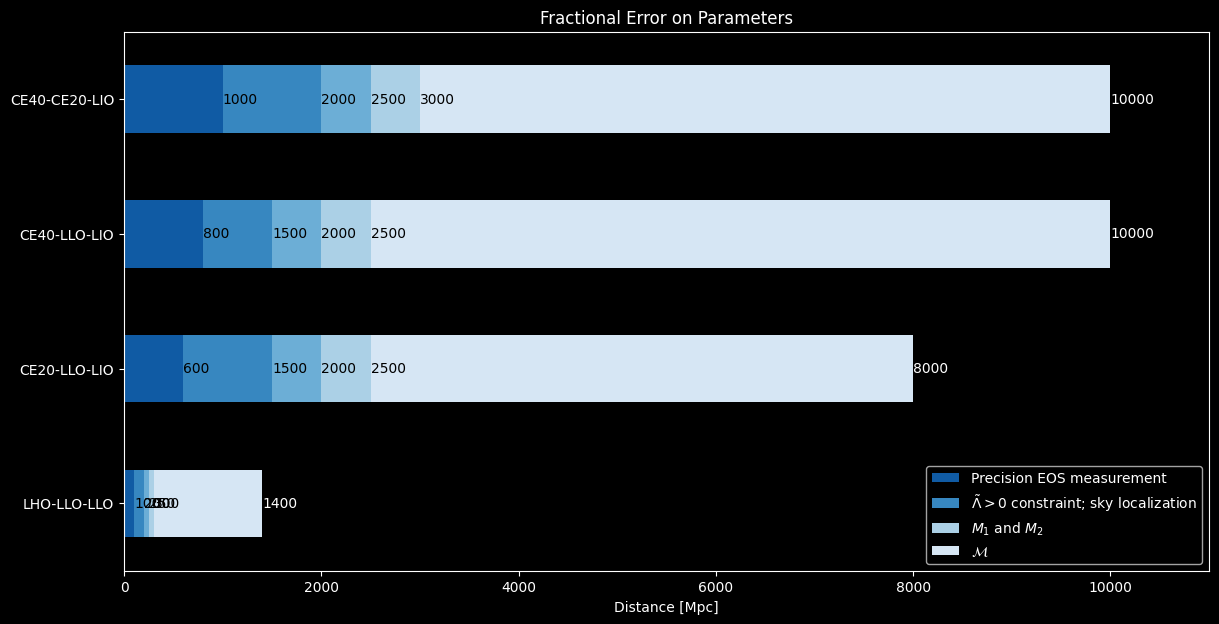

In [5]:
# list of all the network files
network_list = sorted(glob("fractional-error-files/*.txt"), reverse=True)

# example contents of a file:
# {"Name": "DET1-DET3-DET4",
# "EOS": 60,
# "sky loc": 90,
# "Masses": 100,
# "Mchirp": 150}

# initiate a list of names for the detector networks
name_list = []

fig, ax = plt.subplots(figsize=(14,7))
for ii in range(len(network_list)):
    nw_dict = json.load(open(network_list[ii]))
    name = nw_dict['Name']
    print('plotting distances for network {}'.format(name))
    name_list.append(name)
    plot_dist_bar(nw_dict, ii+1)

ax.set_ylim(5, len(network_list)*10+5)
ax.set_xlim(0, 11000)
ax.set_xlabel('Distance [Mpc]')
ax.set_yticks([(ii*10 +10) for ii in range(len(network_list))], 
              labels=name_list)     # Modify y-axis tick labels
# ax.grid(True)                                       

# create legend
legend_elements = [Patch(facecolor=color_dict['EOS'], 
                         label='Precision EOS measurement'),
                   Patch(facecolor=color_dict['sky loc'], 
                         label=r'$\tilde{\Lambda} > 0$ constraint; sky localization'),
                   Patch(facecolor=color_dict['Masses'], 
                         label=r'$M_1$ and $M_2$'),
                   Patch(facecolor=color_dict['Mchirp'], 
                         label=r'$\mathcal{M}$')]
ax.legend(handles=legend_elements, loc=4)
plt.title('Fractional Error on Parameters')
plt.savefig('fractional-errors.png', dpi=200)
plt.show()